In [55]:
#!pip3 install statsmodels
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
from scipy.stats import pearsonr, ttest_ind
from statsmodels.stats.multitest import multipletests
import shortest_path as sp
import random

dir = "/home/ozgunbabur/Data/Josh/take3/"
data_file = dir + "normalized_mat.tsv"
data_file_denoised = dir + "normalized_test_denoised_mat.tsv"

In [32]:
dataF = pd.read_table(data_file, index_col=0)
cells = dataF.columns.values.tolist()
genes = dataF.index.values.tolist()
mat = dataF.to_numpy()

In [33]:
# Hide 1000 of the values

hid_size = 10000
hidden = set()

row = random.randint(0, len(genes)-1)
col = random.randint(0, len(cells)-1)

while len(hidden) < hid_size:
    if mat[row][col] != 0 and mat[row][col] > 2:
        loc = (row, col, mat[row][col])
        hidden.add(loc)
        mat[row][col] = 0

    row = random.randint(0, len(genes)-1)
    col = random.randint(0, len(cells)-1)


In [34]:
# Apply k-rank SVD

k = 100
u, s, vt = randomized_svd(mat, n_components=k, random_state=None)
mat_reduced = np.matmul(np.matmul(u, np.diag(s)), vt)

# Set negative values to 0
for i in range(len(genes)):
    for j in range(len(cells)):
        if mat_reduced[i][j] < 0:
            mat_reduced[i][j] = 0

(0.8062033081070856, 0.0)


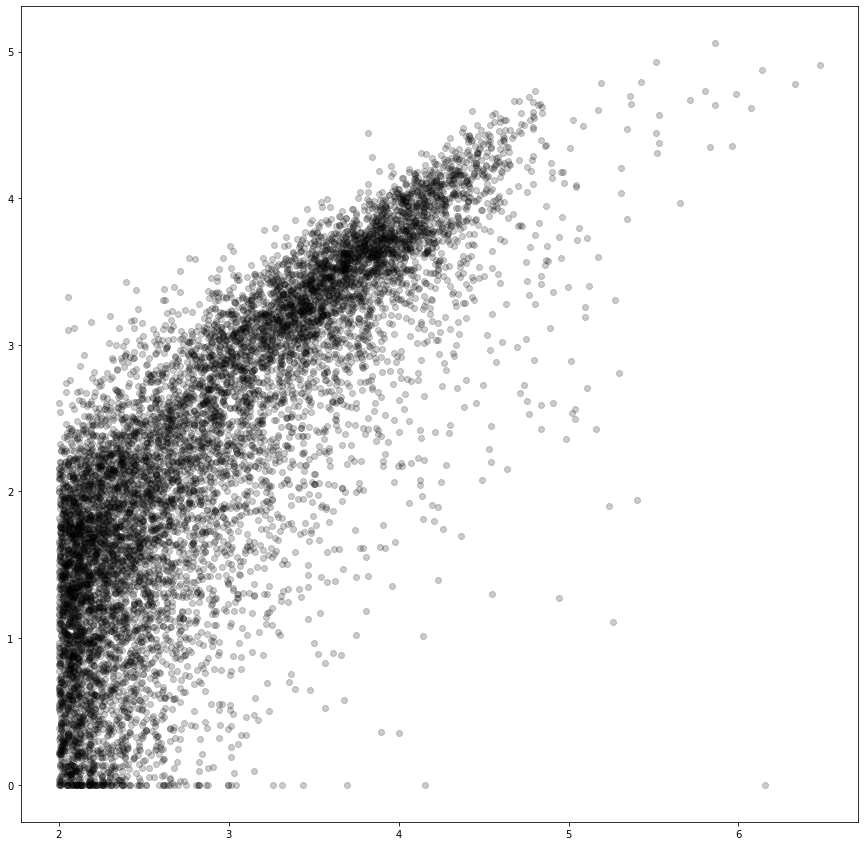

In [35]:
# Plot correlation

x = []
y = []
for loc in hidden:
    x.append(loc[2])
    y.append(mat_reduced[loc[0]][loc[1]])

corr = pearsonr(x, y)
print(corr)

plt.figure(figsize=(15, 15))
ax = plt.axes()
ax.scatter(x, y, color = 'k', alpha=0.2)
plt.show()

In [109]:
# Simulation to see if denoising can introduce noise to DE table

n_genes = 1000
n_cells = 1000

n_test_genes = 100
n_test_cells = 100
n_ctrl_cells = 100

sd = 1
high_val = 4
mid_val = 3
low_val = 2

m = np.zeros((n_genes, n_cells))

gene_categ = []
gene_names = []
for i in range(0, n_test_genes):
    gene_categ.append(0)
    gene_names.append("GT" + str(i))

i = 1
while len(gene_categ) < n_genes:
    gene_categ.append(1)
    gene_names.append("GF" + str(i))
    i += 1

print(len(gene_names))

cell_categ = []
cell_names = []
for i in range(0, n_test_cells):
    cell_categ.append(0)
    cell_names.append("CT" + str(i))
for i in range(0, n_ctrl_cells):
    cell_categ.append(1)
    cell_names.append("CC" + str(i))
i = 1
while len(cell_categ) < n_cells:
    cell_categ.append(2)
    cell_names.append("CO" + str(i))
    i += 1

print(len(cell_names))

for i in range(0, n_genes):
    for j in range(0, n_cells):
        if i < n_test_genes:
            if j < n_test_cells:
                m[i][j] = random.gauss(high_val, sd)
            elif j < n_test_cells + n_ctrl_cells:
                m[i][j] = random.gauss(low_val, sd)
            else:
                m[i][j] = random.gauss(mid_val, sd)
        else:
            m[i][j] = random.gauss(mid_val, sd)

        if m[i][j] < 0:
            m[i][j] = 0

# insert missing values
for times in range(0, int((n_genes * n_cells / 5))):
    i = random.randint(0, n_genes - 1)
    j = random.randint(0, n_cells - 1)
    m[i][j] = 0



df = pd.DataFrame(data=m, index=gene_names, columns=cell_names)
df.to_csv("/home/ozgunbabur/Data/Josh/take3/simulated_mat.tsv", sep="\t")

k = 10
u, s, vt = randomized_svd(m, n_components=k, random_state=None)
m = np.matmul(np.matmul(u, np.diag(s)), vt)

# Set negative values to 0
for i in range(n_genes):
    for j in range(n_cells):
        if m[i][j] < 0:
            m[i][j] = 0

pvals = []

for i in range(0, n_genes):
    a = m[i][n_test_cells : (n_test_cells + n_ctrl_cells)]
    b = m[i][0 : n_test_cells]
    (t, p) = ttest_ind(a, b)
    pvals.append(p)


(select, p_corrected, var1, var2) = multipletests(pvals, 0.1)


c_tp = 0
c_tn = 0
c_fp = 0
c_fn = 0

for i in range(0, n_test_genes):
    if select[i] == True:
        c_tp += 1
    else:
        c_fn += 1
for i in range(n_test_genes, n_genes):
    if select[i] == True:
        c_fp += 1
    else:
        c_tn += 1

print("TP = " + str(c_tp))
print("TN = " + str(c_tn))
print("FP = " + str(c_fp))
print("FN = " + str(c_fn))



1000
1000
TP = 100
TN = 370
FP = 530
FN = 0


In [110]:
print(np.random.random((2, 3)))

[[0.27936769 0.3990997  0.81751877]
 [0.45972181 0.69074879 0.25579323]]
